# Tech Challenge - Fase 1
## Sistema de Diagnóstico de Câncer de Mama

### Objetivo
Desenvolver modelos de Machine Learning para classificação de tumores de mama como **malignos** ou **benignos** utilizando o Wisconsin Breast Cancer Dataset.

### Dataset
- **Fonte**: [UCI Machine Learning Repository via Kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)
- **Descrição**: Características computadas de imagens digitalizadas de aspirado por agulha fina (FNA) de massas mamárias
- **Features**: 30 características numéricas
- **Target**: Diagnóstico (M = maligno, B = benigno)

## 1. Importação de Bibliotecas

In [36]:
# Importações básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Importação dos módulos customizados
import sys
sys.path.append('../src')

from preprocessing import DataPreprocessor
from models import ModelTrainer
from evaluation import ModelEvaluator

# Scikit-learn
from sklearn.datasets import load_breast_cancer

# SHAP para interpretabilidade
import shap
shap.initjs()  # Inicializa o visualizador SHAP

print("✓ Bibliotecas importadas com sucesso!")

✓ Bibliotecas importadas com sucesso!


## 2. Carregamento e Exploração dos Dados

### 2.1 Carregamento do Dataset

In [37]:
# Carrega o dataset diretamente do scikit-learn
data = load_breast_cancer()

# Cria DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
df['diagnosis'] = data.target

# Converte target para labels textuais
df['diagnosis_label'] = df['diagnosis'].map({0: 'M', 1: 'B'})

print(f"Dataset carregado: {df.shape[0]} amostras, {df.shape[1]} colunas")
df.head()

Dataset carregado: 569 amostras, 32 colunas


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis,diagnosis_label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,M


### 2.2 Informações Básicas do Dataset

In [38]:
print("="*70)
print("INFORMAÇÕES DO DATASET")
print("="*70)
print(f"\nDimensões: {df.shape}")
print(f"\nTipos de dados:")
print(df.dtypes.value_counts())
print(f"\nValores ausentes:")
print(df.isnull().sum().sum())
print(f"\nDuplicados: {df.duplicated().sum()}")

INFORMAÇÕES DO DATASET

Dimensões: (569, 32)

Tipos de dados:
float64    30
int64       1
object      1
Name: count, dtype: int64

Valores ausentes:
0

Duplicados: 0


### 2.3 Distribuição das Classes


Distribuição das Classes:
----------------------------------------
Benigno: 357 (62.7%)
Maligno: 212 (37.3%)


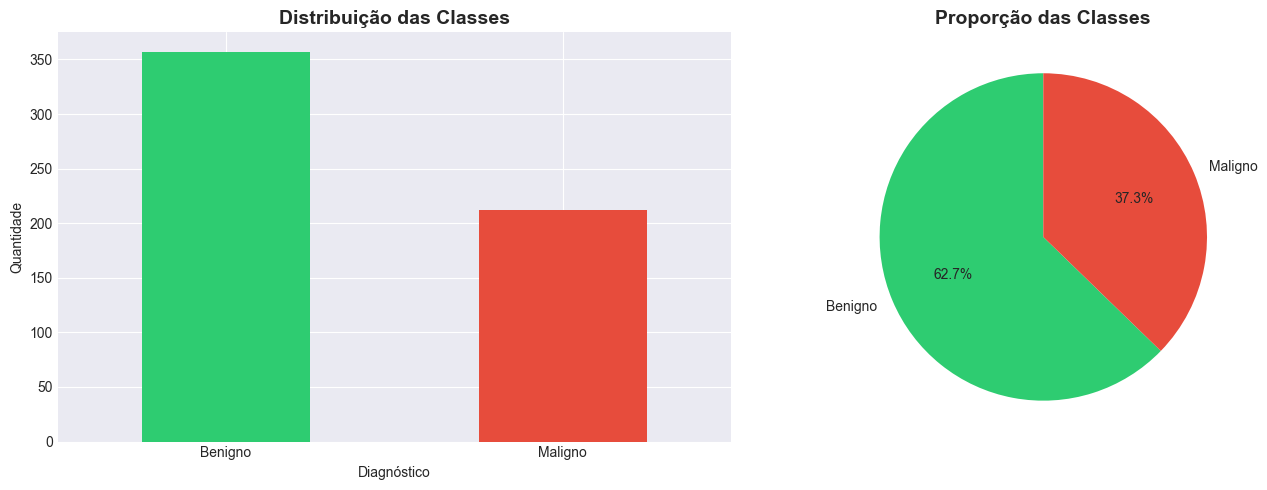

In [39]:
# Análise da distribuição das classes
class_dist = df['diagnosis_label'].value_counts()
class_percent = df['diagnosis_label'].value_counts(normalize=True) * 100

print("\nDistribuição das Classes:")
print("-" * 40)
for label in ['B', 'M']:
    diagnosis_name = 'Benigno' if label == 'B' else 'Maligno'
    print(f"{diagnosis_name}: {class_dist[label]} ({class_percent[label]:.1f}%)")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
class_dist.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribuição das Classes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diagnóstico')
axes[0].set_ylabel('Quantidade')
axes[0].set_xticklabels(['Benigno', 'Maligno'], rotation=0)

# Gráfico de pizza
axes[1].pie(class_dist, labels=['Benigno', 'Maligno'], autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Proporção das Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/graficos/distribuicao_classes.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.4 Estatísticas Descritivas

In [40]:
# Estatísticas descritivas das features numéricas
print("\nEstatísticas Descritivas:")
print("="*70)
df.describe().T


Estatísticas Descritivas:


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


### 2.5 Visualização da Distribuição das Features

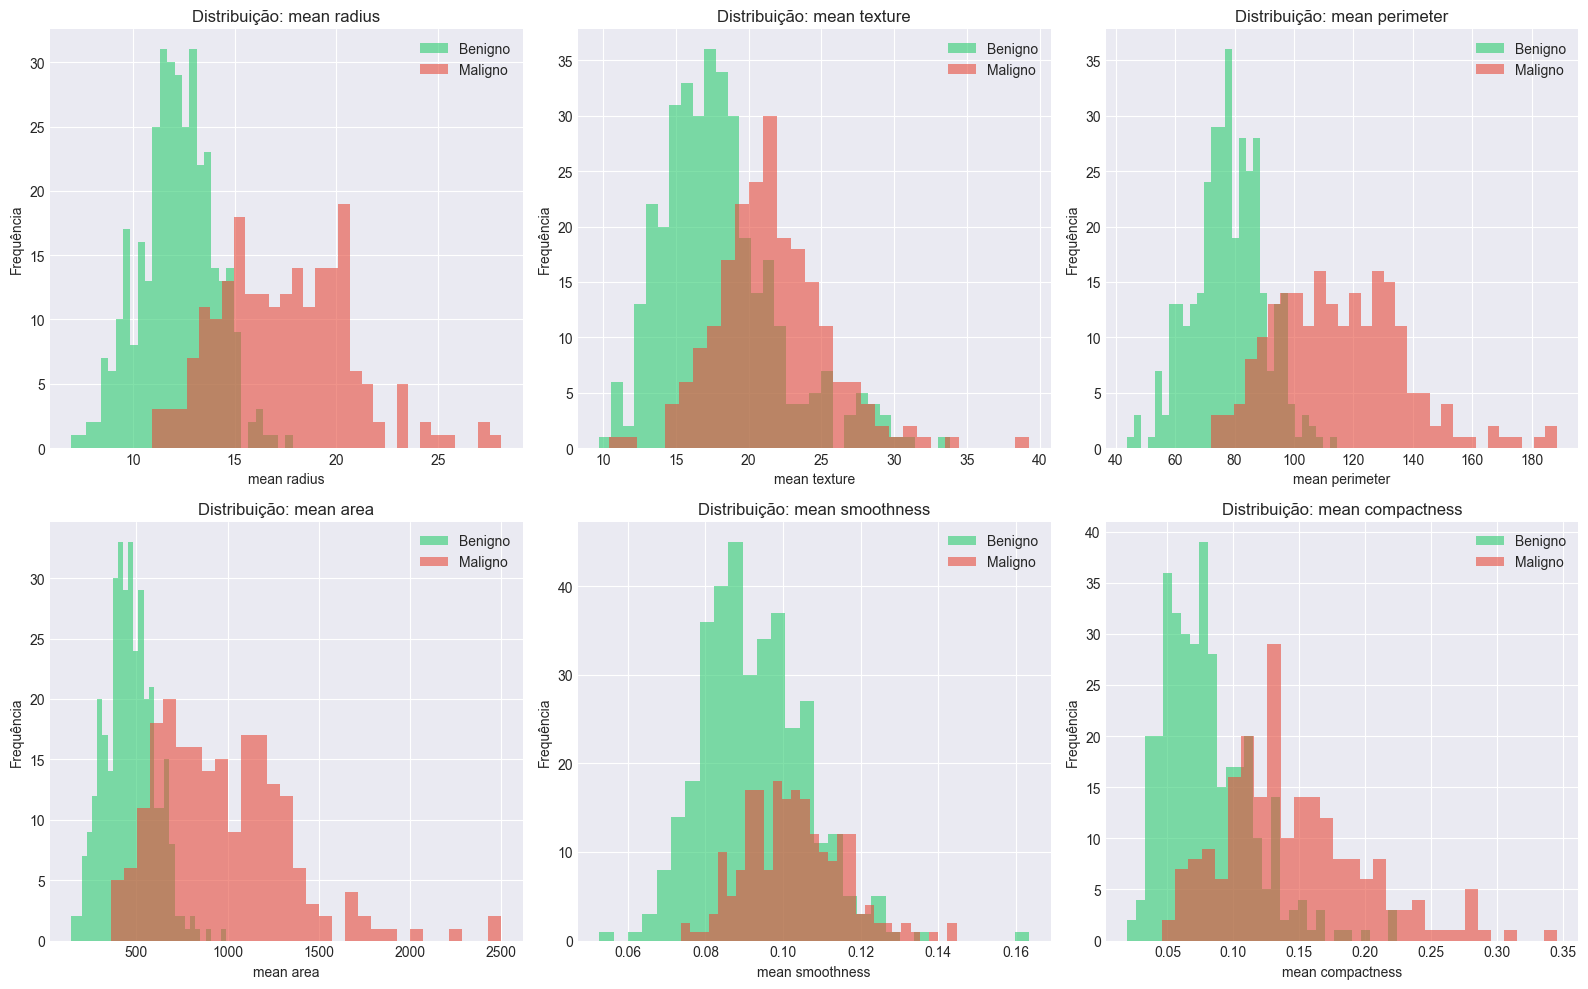

In [41]:
# Seleciona as principais features para visualização
main_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                'mean smoothness', 'mean compactness']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(main_features):
    for diagnosis in ['B', 'M']:
        data_subset = df[df['diagnosis_label'] == diagnosis][feature]
        label = 'Benigno' if diagnosis == 'B' else 'Maligno'
        color = '#2ecc71' if diagnosis == 'B' else '#e74c3c'
        axes[idx].hist(data_subset, alpha=0.6, label=label, bins=30, color=color)
    
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequência')
    axes[idx].legend()
    axes[idx].set_title(f'Distribuição: {feature}')

plt.tight_layout()
plt.savefig('../results/graficos/distribuicao_features.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.6 Análise de Correlação

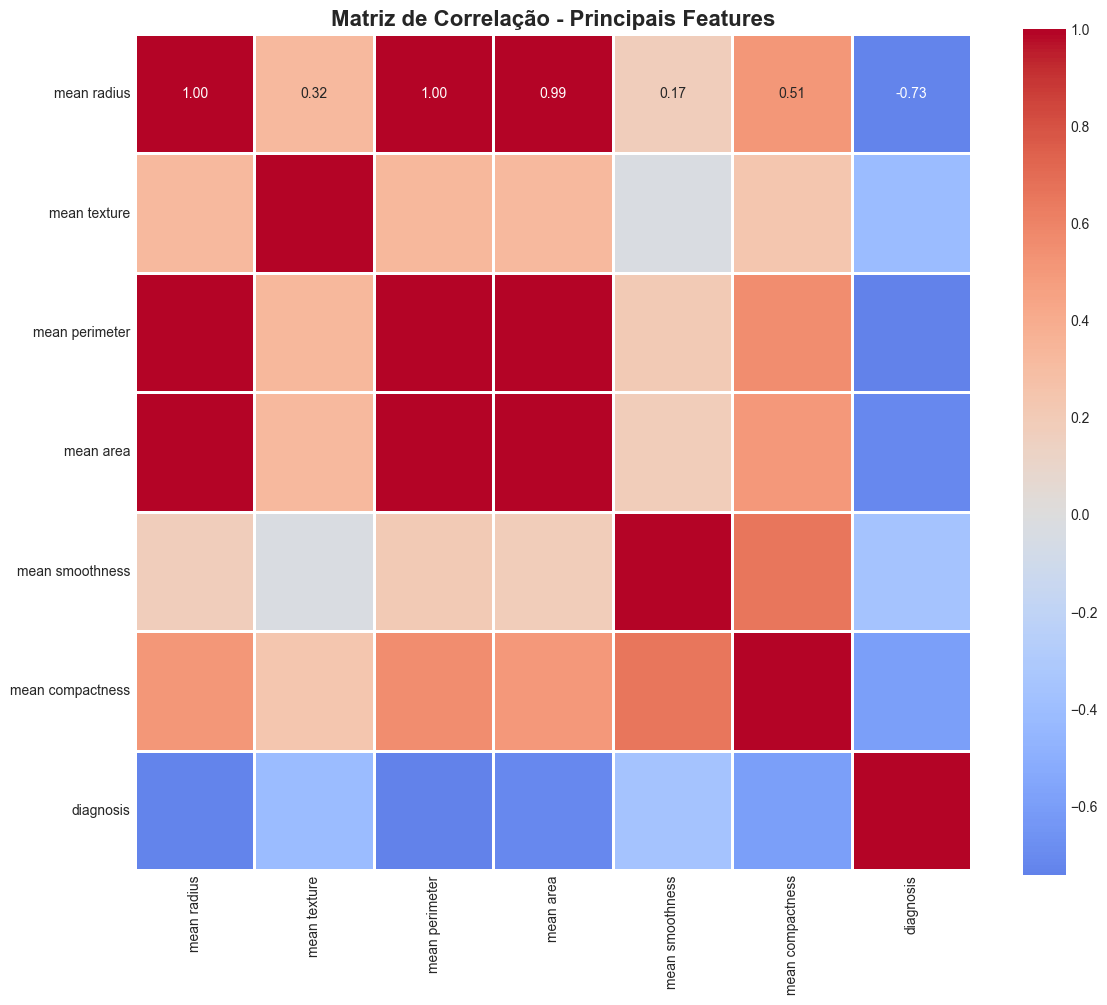


Top 10 Features mais correlacionadas com o diagnóstico:
smoothness error           0.067016
mean fractal dimension     0.012838
texture error              0.008303
symmetry error             0.006522
fractal dimension error   -0.077972
concavity error           -0.253730
compactness error         -0.292999
worst fractal dimension   -0.323872
mean symmetry             -0.330499
mean smoothness           -0.358560
dtype: float64


In [42]:
# Matriz de correlação das principais features
correlation_matrix = df[main_features + ['diagnosis']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Matriz de Correlação - Principais Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/graficos/matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlação com o target
target_corr = df.drop(['diagnosis_label'], axis=1).corrwith(df['diagnosis']).sort_values(ascending=False)
print("\nTop 10 Features mais correlacionadas com o diagnóstico:")
print("="*60)
print(target_corr.head(11)[1:])  # Exclui a própria coluna diagnosis

### 2.7 Análise de Outliers

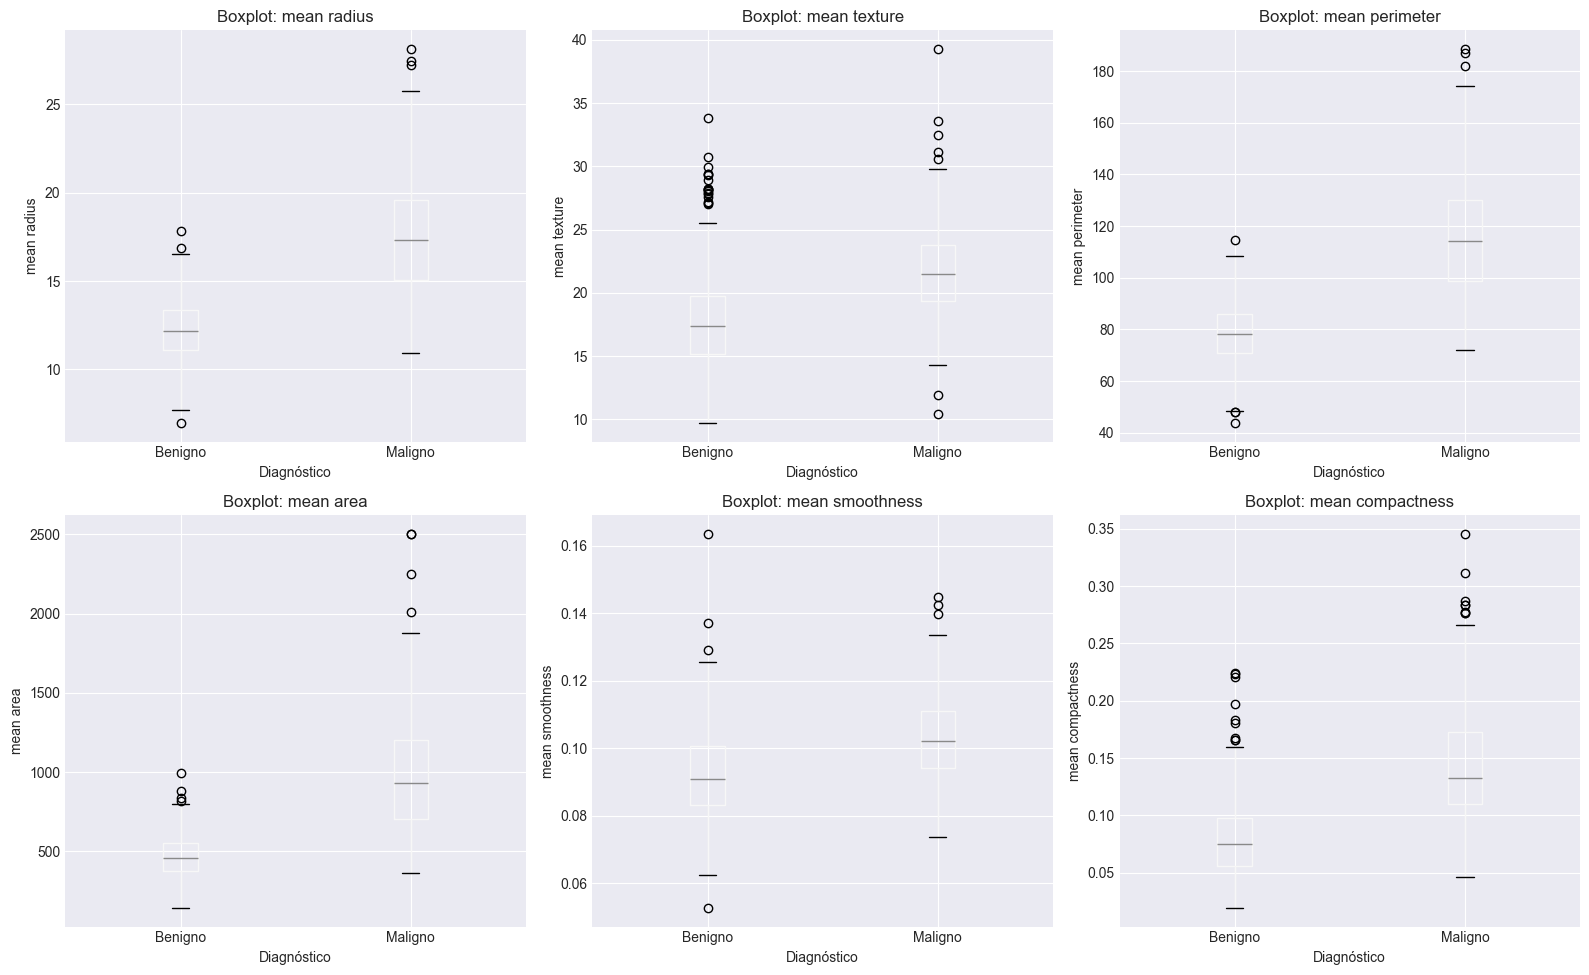

In [43]:
# Boxplot das principais features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(main_features):
    df.boxplot(column=feature, by='diagnosis_label', ax=axes[idx])
    axes[idx].set_xlabel('Diagnóstico')
    axes[idx].set_ylabel(feature)
    axes[idx].set_title(f'Boxplot: {feature}')
    axes[idx].set_xticklabels(['Benigno', 'Maligno'])

plt.suptitle('')  # Remove o título padrão do boxplot
plt.tight_layout()
plt.savefig('../results/graficos/boxplot_features.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Pré-processamento dos Dados

### 3.1 Preparação das Features e Target

In [44]:
# Inicializa o preprocessador
preprocessor = DataPreprocessor()

# Prepara features e target
X = df.drop(['diagnosis', 'diagnosis_label'], axis=1)
y = df['diagnosis_label']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeatures selecionadas: {len(X.columns)}")

Features (X): (569, 30)
Target (y): (569,)

Features selecionadas: 30


### 3.2 Codificação do Target

In [45]:
# Codifica o target (B=0, M=1)
y_encoded = preprocessor.encode_target(y)


Classes codificadas:
  B -> 0
  M -> 1


### 3.3 Divisão em Treino, Validação e Teste

In [46]:
# Divide os dados (60% treino, 20% validação, 20% teste)
X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.split_data(
    X, y_encoded, test_size=0.2, val_size=0.2, random_state=42
)


Divisão dos dados:
  Treino: 341 amostras (59.9%)
  Validação: 114 amostras (20.0%)
  Teste: 114 amostras (20.0%)


### 3.4 Escalonamento das Features

In [47]:
# Aplica StandardScaler
X_train_scaled, X_val_scaled = preprocessor.scale_features(X_train, X_val)
X_train_scaled, X_test_scaled = preprocessor.scale_features(X_train, X_test)

print("\nExemplo de dados antes e depois do escalonamento:")
print("="*60)
print("\nAntes (primeiras 3 features):")
print(X_train.iloc[0, :3])
print("\nDepois (primeiras 3 features):")
print(X_train_scaled.iloc[0, :3])


Features escalonadas (StandardScaler)

Features escalonadas (StandardScaler)

Exemplo de dados antes e depois do escalonamento:

Antes (primeiras 3 features):
mean radius        14.86
mean texture       23.21
mean perimeter    100.40
Name: 194, dtype: float64

Depois (primeiras 3 features):
mean radius       0.193816
mean texture      0.868298
mean perimeter    0.331466
Name: 194, dtype: float64


## 4. Modelagem

### 4.1 Inicialização dos Modelos

In [48]:
# Inicializa o trainer
trainer = ModelTrainer()
trainer.initialize_models()

Modelos inicializados: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'SVM']


### 4.2 Treinamento dos Modelos (Sem Otimização de Hiperparâmetros)

In [49]:
# Treina todos os modelos com parâmetros padrão
models = trainer.train_all_models(X_train_scaled, y_train, tune_hyperparameters=False)


TREINAMENTO DOS MODELOS

Treinando Logistic Regression...

Treinando Decision Tree...

Treinando Random Forest...

Treinando KNN...

Treinando SVM...

Todos os modelos foram treinados!


### 4.3 Avaliação Inicial dos Modelos (Conjunto de Validação)

In [50]:
# Inicializa o evaluator
evaluator = ModelEvaluator()

# Avalia todos os modelos no conjunto de validação
for model_name in models.keys():
    y_pred = trainer.predict(model_name, X_val_scaled)
    y_proba = trainer.predict_proba(model_name, X_val_scaled)
    
    evaluator.evaluate_model(model_name, y_val, y_pred, y_proba)
    evaluator.print_metrics(model_name)


MÉTRICAS - Logistic Regression
Accuracy:  0.9737
Precision: 0.9545
Recall:    0.9767
F1-Score:  0.9655
ROC-AUC:   0.9957

Matriz de Confusão:
[[69  2]
 [ 1 42]]

MÉTRICAS - Decision Tree
Accuracy:  0.8947
Precision: 0.8298
Recall:    0.9070
F1-Score:  0.8667
ROC-AUC:   0.8972

Matriz de Confusão:
[[63  8]
 [ 4 39]]

MÉTRICAS - Random Forest
Accuracy:  0.9737
Precision: 0.9762
Recall:    0.9535
F1-Score:  0.9647
ROC-AUC:   0.9915

Matriz de Confusão:
[[70  1]
 [ 2 41]]

MÉTRICAS - Random Forest
Accuracy:  0.9737
Precision: 0.9762
Recall:    0.9535
F1-Score:  0.9647
ROC-AUC:   0.9915

Matriz de Confusão:
[[70  1]
 [ 2 41]]

MÉTRICAS - KNN
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.9302
F1-Score:  0.9639
ROC-AUC:   0.9948

Matriz de Confusão:
[[71  0]
 [ 3 40]]

MÉTRICAS - SVM
Accuracy:  0.9825
Precision: 0.9767
Recall:    0.9767
F1-Score:  0.9767
ROC-AUC:   0.9961

Matriz de Confusão:
[[70  1]
 [ 1 42]]

MÉTRICAS - KNN
Accuracy:  0.9737
Precision: 1.0000
Recall:    0.9302
F1-Score

### 4.4 Comparação dos Modelos


Comparação de Modelos (Conjunto de Validação):
             Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
                SVM  0.982456   0.976744 0.976744  0.976744 0.996069
Logistic Regression  0.973684   0.954545 0.976744  0.965517 0.995742
      Random Forest  0.973684   0.976190 0.953488  0.964706 0.991484
                KNN  0.973684   1.000000 0.930233  0.963855 0.994759
      Decision Tree  0.894737   0.829787 0.906977  0.866667 0.897150


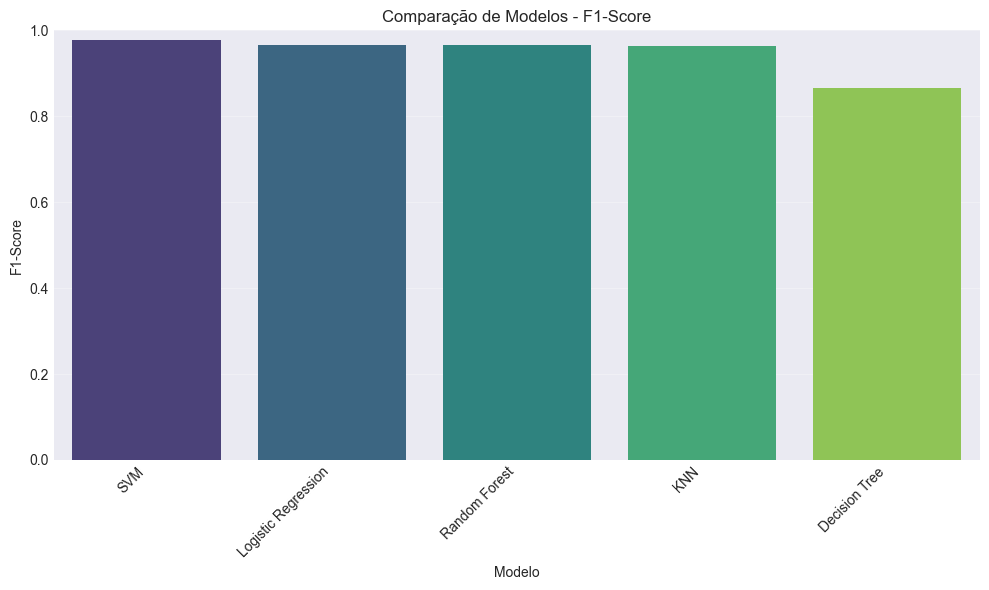

In [51]:
# Compara todos os modelos
comparison_df = evaluator.compare_models()
print("\nComparação de Modelos (Conjunto de Validação):")
print("="*80)
print(comparison_df.to_string(index=False))

# Visualização da comparação
fig = evaluator.plot_comparison(metric='f1_score')
plt.savefig('../results/graficos/comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.5 Seleção do Melhor Modelo

In [52]:
# Seleciona o melhor modelo baseado no F1-Score
best_model_name = comparison_df.iloc[0]['Modelo']
print(f"\n🏆 Melhor modelo: {best_model_name}")
print(f"F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")


🏆 Melhor modelo: SVM
F1-Score: 0.9767


### 4.6 Otimização de Hiperparâmetros do Melhor Modelo

In [53]:
# Treina o melhor modelo com otimização de hiperparâmetros
print(f"\nOtimizando hiperparâmetros do modelo: {best_model_name}")
best_model_optimized = trainer.train_model(
    best_model_name, X_train_scaled, y_train, tune_hyperparameters=True
)


Otimizando hiperparâmetros do modelo: SVM

Treinando SVM com GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Melhor score (CV): 0.9647


## 5. Avaliação Final (Conjunto de Teste)

### 5.1 Predições no Conjunto de Teste

In [54]:
# Realiza predições no conjunto de teste
y_test_pred = trainer.predict(best_model_name, X_test_scaled)
y_test_proba = trainer.predict_proba(best_model_name, X_test_scaled)

# Avalia o modelo
test_evaluator = ModelEvaluator()
test_evaluator.evaluate_model(best_model_name, y_test, y_test_pred, y_test_proba)
test_evaluator.print_metrics(best_model_name)


MÉTRICAS - SVM
Accuracy:  0.9737
Precision: 0.9756
Recall:    0.9524
F1-Score:  0.9639
ROC-AUC:   0.9940

Matriz de Confusão:
[[71  1]
 [ 2 40]]


### 5.2 Matriz de Confusão

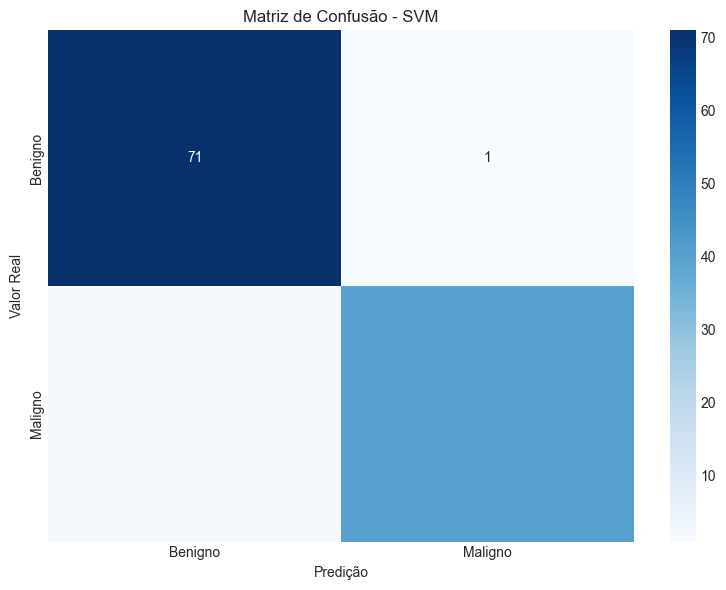

In [55]:
# Plota matriz de confusão
fig = test_evaluator.plot_confusion_matrix(best_model_name)
plt.savefig('../results/graficos/matriz_confusao_teste.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.3 Curva ROC

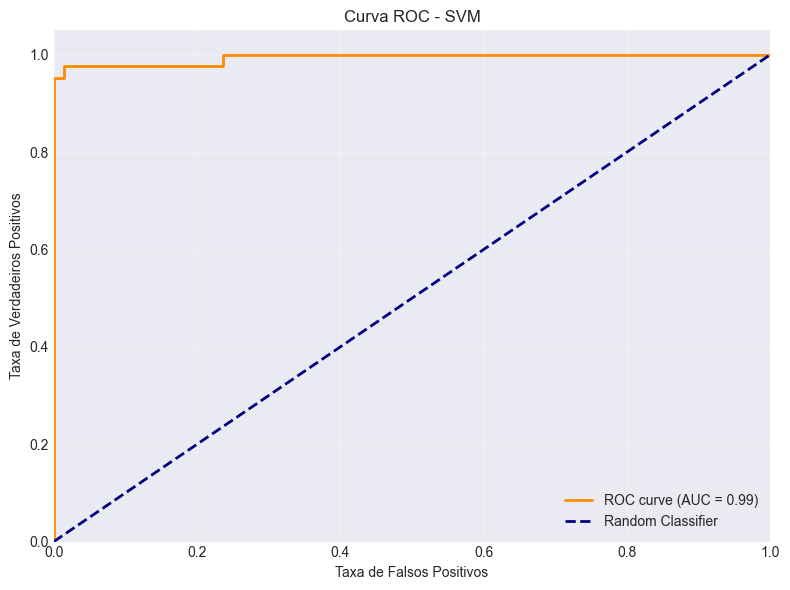

In [56]:
# Plota curva ROC
fig = test_evaluator.plot_roc_curve(best_model_name, y_test, y_test_proba)
plt.savefig('../results/graficos/curva_roc_teste.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.4 Relatório de Classificação Detalhado

In [57]:
from sklearn.metrics import classification_report

print("\nRelatório de Classificação Completo:")
print("="*60)
print(classification_report(y_test, y_test_pred, 
                          target_names=['Benigno (0)', 'Maligno (1)']))


Relatório de Classificação Completo:
              precision    recall  f1-score   support

 Benigno (0)       0.97      0.99      0.98        72
 Maligno (1)       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## 6. Interpretabilidade do Modelo

### 6.1 Importância das Features

In [58]:
# Obtém importância das features
feature_importance = trainer.get_feature_importance(best_model_name)

if feature_importance is not None:
    fig = test_evaluator.plot_feature_importance(
        X_train.columns.tolist(),
        feature_importance,
        best_model_name,
        top_n=15
    )
    plt.savefig('../results/graficos/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(f"O modelo {best_model_name} não possui feature importance nativa.")

O modelo SVM não possui feature importance nativa.


### 6.2 Análise SHAP (Interpretabilidade Avançada)

In [59]:
import shap

# Cria explainer SHAP (KernelExplainer para SVC)
model = best_model_optimized  # Usando o modelo otimizado
# Criamos um sample do conjunto de treino para background
background = shap.sample(X_train_scaled, 100)  # usando 100 amostras para background
explainer = shap.KernelExplainer(model.predict_proba, background)

# Calcula valores SHAP para uma amostra do conjunto de teste (pode demorar um pouco)
sample_size = min(100, len(X_test_scaled))  # limitando a 100 amostras para análise
X_test_sample = shap.sample(X_test_scaled, sample_size)
shap_values = explainer.shap_values(X_test_sample)

print(f"Valores SHAP calculados para interpretação do modelo (amostra de {sample_size} instâncias)")

  0%|          | 0/100 [00:00<?, ?it/s]

Valores SHAP calculados para interpretação do modelo (amostra de 100 instâncias)


<Figure size 1200x800 with 0 Axes>

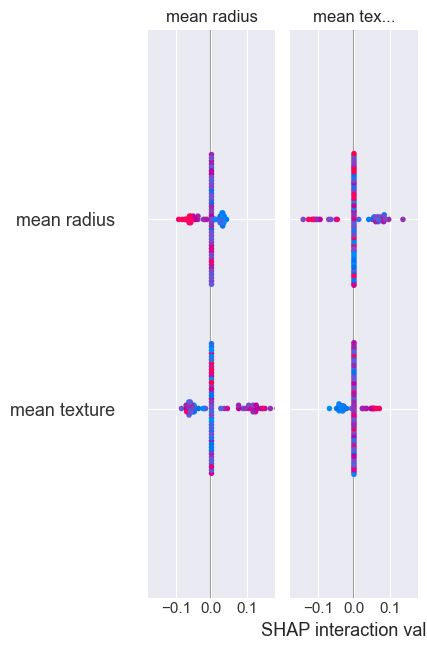

In [60]:
# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="violin", feature_names=X_test.columns, show=False)
plt.tight_layout()
plt.savefig('../results/graficos/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x800 with 0 Axes>

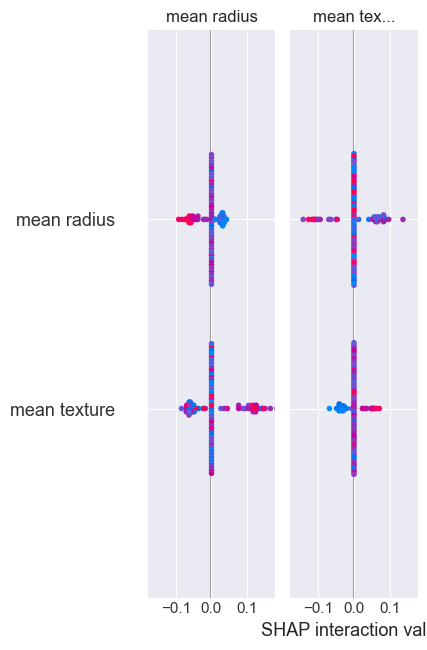

In [61]:
# Bar plot - importância média absoluta
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", feature_names=X_test.columns, show=False)
plt.tight_layout()
plt.savefig('../results/graficos/shap_bar.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Análise de Erros

### 7.1 Casos Mal Classificados

In [62]:
# Identifica casos mal classificados
misclassified_indices = np.where(y_test != y_test_pred)[0]
misclassified_df = pd.DataFrame({
    'Índice': X_test.iloc[misclassified_indices].index,
    'Valor Real': ['Maligno' if y == 1 else 'Benigno' for y in y_test[misclassified_indices]],
    'Predição': ['Maligno' if y == 1 else 'Benigno' for y in y_test_pred[misclassified_indices]],
    'Probabilidade Maligno': y_test_proba[misclassified_indices, 1]
})

print(f"\nTotal de casos mal classificados: {len(misclassified_indices)}")
print(f"Taxa de erro: {len(misclassified_indices)/len(y_test)*100:.2f}%\n")
print("Exemplos de casos mal classificados:")
print("="*70)
print(misclassified_df.head(10).to_string(index=False))


Total de casos mal classificados: 3
Taxa de erro: 2.63%

Exemplos de casos mal classificados:
 Índice Valor Real Predição  Probabilidade Maligno
     73    Maligno  Benigno               0.043370
    208    Benigno  Maligno               0.589048
    205    Maligno  Benigno               0.468988


### 7.2 Análise dos Falsos Positivos e Falsos Negativos

In [63]:
from sklearn.metrics import confusion_matrix

# Calcula matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print("\nAnálise Detalhada dos Erros:")
print("="*60)
print(f"Verdadeiros Negativos (TN): {tn} - Casos benignos corretamente identificados")
print(f"Verdadeiros Positivos (TP): {tp} - Casos malignos corretamente identificados")
print(f"\n⚠️  Falsos Positivos (FP): {fp} - Casos benignos classificados como malignos")
print(f"⚠️  Falsos Negativos (FN): {fn} - Casos malignos classificados como benignos")

print(f"\n💡 Interpretação Clínica:")
print(f"   - Falsos Positivos podem gerar ansiedade e exames desnecessários")
print(f"   - Falsos Negativos são mais críticos, pois casos malignos não seriam tratados")
print(f"   - O modelo deve priorizar reduzir Falsos Negativos (alto Recall)")


Análise Detalhada dos Erros:
Verdadeiros Negativos (TN): 71 - Casos benignos corretamente identificados
Verdadeiros Positivos (TP): 40 - Casos malignos corretamente identificados

⚠️  Falsos Positivos (FP): 1 - Casos benignos classificados como malignos
⚠️  Falsos Negativos (FN): 2 - Casos malignos classificados como benignos

💡 Interpretação Clínica:
   - Falsos Positivos podem gerar ansiedade e exames desnecessários
   - Falsos Negativos são mais críticos, pois casos malignos não seriam tratados
   - O modelo deve priorizar reduzir Falsos Negativos (alto Recall)


## 8. Avaliação de Todos os Modelos no Conjunto de Teste

In [64]:
# Avalia todos os modelos no conjunto de teste
all_test_evaluator = ModelEvaluator()

print("\n" + "="*70)
print("AVALIAÇÃO FINAL DE TODOS OS MODELOS (CONJUNTO DE TESTE)")
print("="*70)

for model_name in models.keys():
    y_pred = trainer.predict(model_name, X_test_scaled)
    y_proba = trainer.predict_proba(model_name, X_test_scaled)
    
    all_test_evaluator.evaluate_model(model_name, y_test, y_pred, y_proba)

# Comparação final
final_comparison = all_test_evaluator.compare_models()
print("\n" + final_comparison.to_string(index=False))


AVALIAÇÃO FINAL DE TODOS OS MODELOS (CONJUNTO DE TESTE)

             Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.973684   0.975610 0.952381  0.963855 0.995370
                SVM  0.973684   0.975610 0.952381  0.963855 0.994048
      Random Forest  0.956140   0.974359 0.904762  0.938272 0.998016
                KNN  0.947368   0.973684 0.880952  0.925000 0.982308
      Decision Tree  0.903509   0.897436 0.833333  0.864198 0.888889


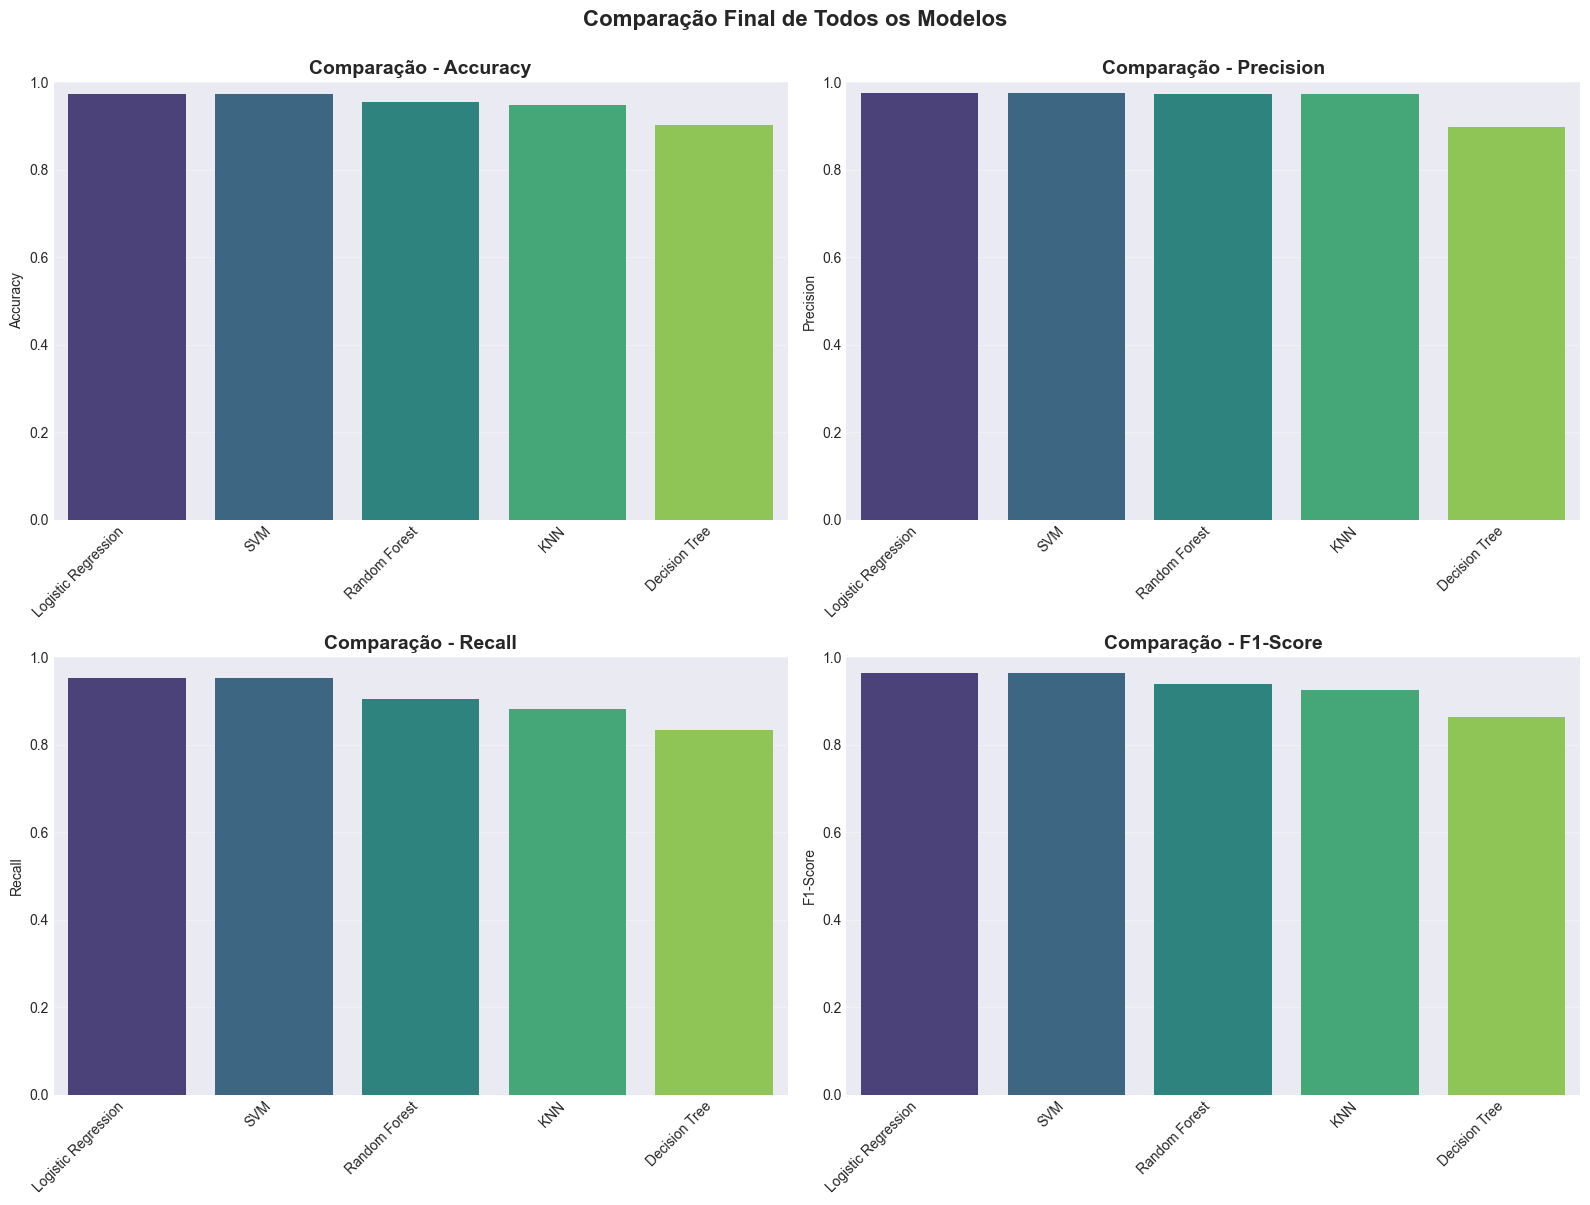

In [65]:
# Visualização da comparação final
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    sns.barplot(data=final_comparison, x='Modelo', y=metric, ax=axes[idx], palette='viridis')
    axes[idx].set_title(f'Comparação - {metric}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xlabel('')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Comparação Final de Todos os Modelos', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('../results/graficos/comparacao_final_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Discussão e Conclusões

### 9.1 Análise dos Resultados

In [66]:
print("\n" + "="*70)
print("DISCUSSÃO DOS RESULTADOS")
print("="*70)

print(f"\n1. MODELO SELECIONADO: {best_model_name}")
print("-" * 70)

best_results = final_comparison.iloc[0]
print(f"   - Accuracy:  {best_results['Accuracy']:.4f}")
print(f"   - Precision: {best_results['Precision']:.4f}")
print(f"   - Recall:    {best_results['Recall']:.4f}")
print(f"   - F1-Score:  {best_results['F1-Score']:.4f}")
print(f"   - ROC-AUC:   {best_results['ROC-AUC']:.4f}")

print("\n2. ESCOLHA DAS MÉTRICAS")
print("-" * 70)
print("""   No contexto de diagnóstico médico de câncer:
   
   • Recall (Sensibilidade): MÉTRICA MAIS IMPORTANTE
     - Mede a capacidade de identificar casos malignos
     - Falsos Negativos (FN) são muito perigosos: paciente com câncer não seria tratado
     - Queremos minimizar FN, maximizando o Recall
   
   • Precision (Precisão):
     - Mede a confiabilidade quando o modelo prediz maligno
     - Falsos Positivos (FP) geram ansiedade e exames extras, mas são menos críticos
   
   • F1-Score:
     - Média harmônica entre Precision e Recall
     - Boa métrica para balancear ambos os aspectos
   
   • ROC-AUC:
     - Avalia a capacidade geral de discriminação do modelo
     - Útil para comparar modelos independente do threshold
""")

print("\n3. APLICABILIDADE PRÁTICA")
print("-" * 70)
print("""   Este modelo PODE ser utilizado como FERRAMENTA DE APOIO, mas:
   
   ✓ ADEQUADO para:
     - Sistema de triagem inicial
     - Segunda opinião automatizada
     - Priorização de casos para revisão humana
     - Redução de carga de trabalho médica
   
   ✗ NÃO ADEQUADO para:
     - Diagnóstico final sem revisão médica
     - Substituir completamente a análise humana
     - Decisões de tratamento sem confirmação
   
   ⚠️  CONSIDERAÇÕES IMPORTANTES:
     - O médico SEMPRE deve ter a palavra final
     - O modelo é uma ferramenta de suporte à decisão
     - Requer validação contínua com novos dados
     - Deve ser monitorado quanto a viés e performance
     - Necessita aprovação regulatória para uso clínico real
""")


DISCUSSÃO DOS RESULTADOS

1. MODELO SELECIONADO: SVM
----------------------------------------------------------------------
   - Accuracy:  0.9737
   - Precision: 0.9756
   - Recall:    0.9524
   - F1-Score:  0.9639
   - ROC-AUC:   0.9954

2. ESCOLHA DAS MÉTRICAS
----------------------------------------------------------------------
   No contexto de diagnóstico médico de câncer:

   • Recall (Sensibilidade): MÉTRICA MAIS IMPORTANTE
     - Mede a capacidade de identificar casos malignos
     - Falsos Negativos (FN) são muito perigosos: paciente com câncer não seria tratado
     - Queremos minimizar FN, maximizando o Recall

   • Precision (Precisão):
     - Mede a confiabilidade quando o modelo prediz maligno
     - Falsos Positivos (FP) geram ansiedade e exames extras, mas são menos críticos

   • F1-Score:
     - Média harmônica entre Precision e Recall
     - Boa métrica para balancear ambos os aspectos

   • ROC-AUC:
     - Avalia a capacidade geral de discriminação do modelo
    

### 9.2 Limitações e Trabalhos Futuros

In [67]:
print("\n4. LIMITAÇÕES DO ESTUDO")
print("-" * 70)
print("""   
   • Dataset relativamente pequeno (569 amostras)
   • Dados de uma única instituição (Wisconsin)
   • Features extraídas de um tipo específico de exame (FNA)
   • Não considera informações clínicas adicionais (idade, histórico, etc.)
   • Classes ligeiramente desbalanceadas
""")

print("\n5. PROPOSTAS PARA TRABALHOS FUTUROS")
print("-" * 70)
print("""   
   • Aumentar o dataset com dados de múltiplas instituições
   • Implementar ensemble de múltiplos modelos
   • Adicionar análise de imagens com Deep Learning (CNN)
   • Incorporar dados clínicos complementares
   • Desenvolver interface web para uso prático
   • Implementar explicações mais detalhadas para cada predição
   • Realizar validação externa com dados de outras instituições
   • Estudar impacto de diferentes thresholds de classificação
""")


4. LIMITAÇÕES DO ESTUDO
----------------------------------------------------------------------
   
   • Dataset relativamente pequeno (569 amostras)
   • Dados de uma única instituição (Wisconsin)
   • Features extraídas de um tipo específico de exame (FNA)
   • Não considera informações clínicas adicionais (idade, histórico, etc.)
   • Classes ligeiramente desbalanceadas


5. PROPOSTAS PARA TRABALHOS FUTUROS
----------------------------------------------------------------------
   
   • Aumentar o dataset com dados de múltiplas instituições
   • Implementar ensemble de múltiplos modelos
   • Adicionar análise de imagens com Deep Learning (CNN)
   • Incorporar dados clínicos complementares
   • Desenvolver interface web para uso prático
   • Implementar explicações mais detalhadas para cada predição
   • Realizar validação externa com dados de outras instituições
   • Estudar impacto de diferentes thresholds de classificação



## 10. Salvamento do Modelo

In [68]:
import joblib

# Salva o melhor modelo
model_path = f'../results/{best_model_name.replace(" ", "_").lower()}_model.pkl'
joblib.dump(model, model_path)

# Salva o scaler
scaler_path = '../results/scaler.pkl'
joblib.dump(preprocessor.scaler, scaler_path)

print(f"\n✓ Modelo salvo em: {model_path}")
print(f"✓ Scaler salvo em: {scaler_path}")
print("\nPara carregar o modelo:")
print("model = joblib.load('model_path')")
print("scaler = joblib.load('scaler_path')")


✓ Modelo salvo em: ../results/svm_model.pkl
✓ Scaler salvo em: ../results/scaler.pkl

Para carregar o modelo:
model = joblib.load('model_path')
scaler = joblib.load('scaler_path')


## 11. Resumo Final

In [69]:
print("\n" + "="*70)
print("RESUMO EXECUTIVO DO PROJETO")
print("="*70)

print(f"""
📊 DATASET:
   - Wisconsin Breast Cancer Dataset
   - {len(df)} amostras, {len(data.feature_names)} features
   - Classes: Benigno ({class_percent['B']:.1f}%), Maligno ({class_percent['M']:.1f}%)

🔧 PRÉ-PROCESSAMENTO:
   - Limpeza de dados (sem valores ausentes)
   - Codificação do target (B=0, M=1)
   - Divisão: {len(X_train)} treino, {len(X_val)} validação, {len(X_test)} teste
   - Escalonamento com StandardScaler

🤖 MODELOS AVALIADOS:
   {chr(10).join(f'   - {name}' for name in models.keys())}

🏆 MELHOR MODELO: {best_model_name}
   - Accuracy:  {best_results['Accuracy']:.4f}
   - Precision: {best_results['Precision']:.4f}
   - Recall:    {best_results['Recall']:.4f}
   - F1-Score:  {best_results['F1-Score']:.4f}
   - ROC-AUC:   {best_results['ROC-AUC']:.4f}

✅ CONCLUSÃO:
   O modelo desenvolvido apresenta excelente performance e pode ser utilizado
   como ferramenta de suporte ao diagnóstico médico, sempre com supervisão
   profissional e como segunda opinião automatizada.

""")

print("="*70)
print("PROJETO CONCLUÍDO COM SUCESSO!")
print("="*70)


RESUMO EXECUTIVO DO PROJETO

📊 DATASET:
   - Wisconsin Breast Cancer Dataset
   - 569 amostras, 30 features
   - Classes: Benigno (62.7%), Maligno (37.3%)

🔧 PRÉ-PROCESSAMENTO:
   - Limpeza de dados (sem valores ausentes)
   - Codificação do target (B=0, M=1)
   - Divisão: 341 treino, 114 validação, 114 teste
   - Escalonamento com StandardScaler

🤖 MODELOS AVALIADOS:
      - Logistic Regression
   - Decision Tree
   - Random Forest
   - KNN
   - SVM

🏆 MELHOR MODELO: SVM
   - Accuracy:  0.9737
   - Precision: 0.9756
   - Recall:    0.9524
   - F1-Score:  0.9639
   - ROC-AUC:   0.9954

✅ CONCLUSÃO:
   O modelo desenvolvido apresenta excelente performance e pode ser utilizado
   como ferramenta de suporte ao diagnóstico médico, sempre com supervisão
   profissional e como segunda opinião automatizada.


PROJETO CONCLUÍDO COM SUCESSO!
